# Latent Factor Models

## 0. Graphs

An undirected graph $G$ is defined by two sets of objects, **nodes** and **edges**. Formally: 
$$G = \bigl\{ \text{nodes}: \{ x_1, \dots , x_m \}, \text{edges}: \{ (x_1, x_i), \dots \} \bigr\}, \quad i \in \{1, \dots , m\}$$

where $m$ is the number of nodes in the graph and the number of edges in the graph is at most $\frac{1}{2} m(m+1)$. 

Let's formally build a graph. We begin by defining the node set:

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

m = 4
for i in range(1, m + 1):
    G.add_node(f'x_{i}')

G.nodes

NodeView(('x_1', 'x_2', 'x_3', 'x_4'))

Next, the edge set: 

In [47]:
edges = [
    ('x_1', 'x_2'),
    ('x_1', 'x_3'),
    ('x_2', 'x_3'),
    ('x_2', 'x_4'),
    ('x_3', 'x_3'),
    ('x_4', 'x_4')
]

G.add_edges_from(edges)

assert len(edges) == len(list(G.edges)); G.edges

EdgeView([('x_1', 'x_2'), ('x_1', 'x_3'), ('x_2', 'x_3'), ('x_2', 'x_4'), ('x_3', 'x_3'), ('x_4', 'x_4')])

We can visualize the nodes and edges:

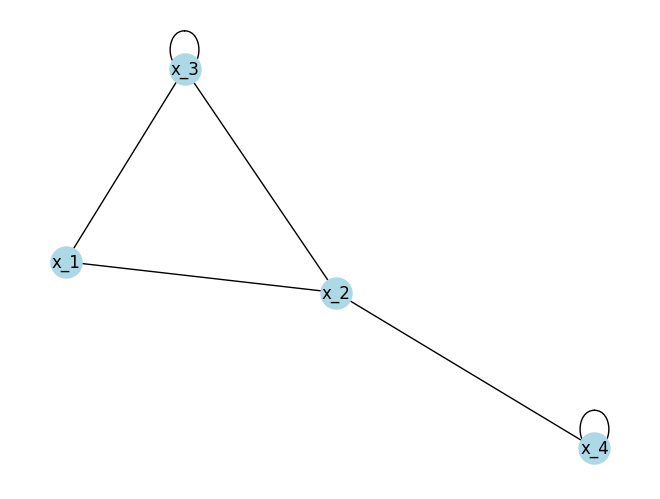

In [42]:
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500)

The edges of $G$ can also be represented as an **adjanceny matrix** as follows: 

$$
\textbf{A} = 
\begin{pmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 1 & 1 \\
1 & 1 & 1 & 0 \\
0 & 1 & 0 & 1\
\end{pmatrix}
$$

When an element $a_{ij} = 1$ this indicates that an edge exists between nodes $i$ and $j$. 

Note that the quantity $\frac{1}{2} m(m+1)$ includes the diagnoal and either the upper- **or** lower-triangular portion of the adjacency matrix. Since $G$ is undirected both the upper- and lower-triangular portions of the adjacency matrix are identical. 

## I. Matrix Factorization

### What is Matrix Factorization? 

Matrix factorization is a dimensionality reduction technique which can be expressed as the following general optimization problem

$$ \min_{\textbf{W}} \quad \mathcal{L} \ \big( \ \textbf{X}, \textbf{W} \textbf{W}^\top \ \big) $$

where

$
\begin{aligned} 
\quad\textbf{X} & \quad \text{is an} \  m \times m \ \text{input matrix}, \\
\quad\textbf{W} & \quad \text{is an} \  m \text{-row output matrix}, \\
\quad\mathcal{L} & \quad \text{is a loss function}. 
\end{aligned}
$

The column dimension of the output matrix is set to $k$ where $k < m$. Plugging in the adjancency matrix as the input, the loss effectively measures the difference between $a_{ij}$ and $f(\textbf{w}_i \textbf{w}_j^{\top} )$ where each vector $\textbf{w}_i$ is trained to be a *latent representation* of node $x_i$. The trained latent representations are useful for a variety of downstream tasks. 

In the example graph the nodes are *not* partitioned so edges exist between nodes including self-connections. Bipartite graphs are comprised of two partitions of nodes where nodes in the same partition do not have edges with each other and only have edges with nodes in the other partition. 

Matrix factorization for bipartite graphs can be expressed as the following general optimization problem:

$$ \min_{\textbf{U}, \textbf{V}} \quad \mathcal{L} \ \big( \ \textbf{X}, \textbf{U} \textbf{V}^\top \ \big) $$

where:

$
\begin{aligned} 
\quad\textbf{X} & \quad \text{is an} \  m \times n \ \text{input matrix}, \\
\quad\textbf{U} & \quad \text{is an} \  m \text{-row output matrix}, \\
\quad\textbf{V} & \quad \text{is an} \  n \text{-row output matrix}, \\
\quad\mathcal{L} & \quad \text{is a loss function}. 
\end{aligned}
$

Minimizing the loss function effectively **factors** the input matrix into the product of two *thin* output matrices. In real world problems the input matrix is typically very sparse: most of the elements $x_{ij}, \ i \in \{1, \dots, m \}, \ j \in \{1, \dots, n \}$ are empty. The information that *is* contained in the input matrix is encoded in a latent space $\mathbb{R}^k$ by setting the column dimension of the output matrices to be $k$ where $k \ll \{m, n\}$. 

In general elements of an input matrix where $x_{ij} = 1$ represent **interactions**. Examples of interactions that can be modelled in this way include customers and items purchased, patients and medications prescribed, or products manufactured and defects reported. 

### Interaction Dataset & Training Utilities

We will build a synthetic interaction dataset where $m, n$ are sufficiently large. Each $i$ will have up to $4$ corresponding $j$:

In [1]:
from src.utils import make_interactions_train_test

m = 1_000_000
n = 1_000
max_j_per_i = 4

interactions_train, interactions_test = make_interactions_train_test(m, n, max_j_per_i)

print(f'The sparsity of the input matrix is {1 - ((len(interactions_train) + len(interactions_test)) / (m * n))}.\n\
There input matrix has been split into {len(interactions_train)} training interactions and {len(interactions_test)} testing interactions.')

The sparsity of the input matrix is 0.997499382.
There input matrix has been split into 1876235 training interactions and 624383 testing interactions.


Next, we will build a dictionary object that combines both the training interactions and testing interactions which will aid in generating negative samples. 

In [2]:
from src.utils import build_dictionary

D = build_dictionary([interactions_train, interactions_test])

The dictionary `D` is important because it will assist in the negative sampling phase. Consider the following scenario: $x_i$ has interactions in both the train and test sets. If we do not check `D` before sampling a negative when collating a training batch then it is possible that the particular $x_{ij}$ sampled negative for training is actually *positive* in the test set. Because there are so few relative positive examples controlling Type I error during batch collation is important for the same reason that the risk of data leakage from negative samples isn't. 

In [3]:
from src.utils import InteractionDataset
from src.utils import collate_fn
from src.utils import build_loader

In [4]:
train_dataset = InteractionDataset(interactions_train)
test_dataset = InteractionDataset(interactions_test)

In [ ]:
device = 'mps'

batch_size = 10

num_workers = 4

collate_kwargs = {'D': D, 'num_n': n, 'negatives': 1}

train_loader = build_loader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    collate_fn=collate_fn,
    collate_kwargs=collate_kwargs,
    device = device
)

test_loader = build_loader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
    collate_fn=collate_fn,
    collate_kwargs=collate_kwargs,
    device = device
)

### Training